# DreamBooth Training / Inference Tutorial

### Note:

Currently, this notebook must be run in a NeMo container. An example command to launch the container:

```bash
docker run --runtime=nvidia --gpus all -it --rm -v <your_nemo_dir>:/opt/NeMo --shm-size=8g -p 8888:8888 \
           --ulimit memlock=-1 --ulimit stack=67108864 <your_nemo_container>
```

## Introduction

This guide walks you through the process of training DreamBooth in NeMo. [DreamBooth](https://arxiv.org/abs/2208.12242) is originally developed by Google using the Imagen as the base model. NeMo's implementation, however, is based on Stable Diffusion. We'll cover the following topics in this tutorial:

1. Downloading and setting up the dataset along with the pretrained stable diffusion checkpoints.
2. Conducting training using either the online encoding or pre-cached latents.
3. Running inference using the fine-tuned model weights.

## Prepare Dataset And Checkpoint
DreamBooth finetunes a pretrained diffusion model using images of a particular object. Sample datasets can be accessed at https://github.com/google/dreambooth. To demonstrate that, we'll use the dataset/dog6 dataset. Here is an example to download the images into a specified directory.

In [ ]:
# Create a dataset directory and download instance images

import os
import wget
DATA_DIR = '/datasets/instance_dir'
os.makedirs(DATA_DIR, exist_ok=True)

urls = [f'https://github.com/google/dreambooth/blob/main/dataset/dog6/0{i}.jpg?raw=true' for i in range(5)]

for i, url in enumerate(urls):
    wget.download(url, out=f'{DATA_DIR}/image0{i}.jpg')

Following that, we'll retrieve the pretrained Stable Diffusion checkpoints from Huggingface as our starting point. Two checkpoints are essential: one for the pretrained U-Net weights and the other for the Variational Auto Encoder (VAE).

In [ ]:
CKPT_DIR = '/ckpts'
os.makedirs(CKPT_DIR, exist_ok=True)

#There are multiple versions of open-sourced Stable Diffusion checkpoints available on Huggingface, below are the links to U-Net and VAE checkpoints of Stable Diffusion v1.5 at https://huggingface.co/runwayml/stable-diffusion-v1-5/tree/main
unet_url = 'https://huggingface.co/runwayml/stable-diffusion-v1-5/resolve/main/unet/diffusion_pytorch_model.bin' 
vae_url = 'https://huggingface.co/runwayml/stable-diffusion-v1-5/resolve/main/vae/diffusion_pytorch_model.bin'

wget.download(unet_url, out=f'{CKPT_DIR}/unet.bin')
wget.download(vae_url, out=f'{CKPT_DIR}/vae.bin')

## Model Config Setup

An example configuration file is readily available at `/opt/NeMo/examples/multimodal/generative/dreambooth/conf/dreambooth.yaml`. We'll kick off with the simplest scenario, finetuning the model using a single node and a single GPU. First, let's review the default configuration file.

The trainer section defines number of nodes, number of GPUs and precision used in mixed precision training.
```yaml
config.trainer.devices = 1 # number of GPUs
config.trainer.num_nodes = 1 # number of nodes
config.trainer.precision = 'bf16-mixed' # mixed precision training with bf16, other options are '16-mixed' (fp16) and '32-true' (tf32)
```

For the CLIP text encoder, we use the NeMo CLIP architecture so one needs to convert the pretrained checkpoint from `open_clip` to Nemo format. Here is the example to run the conversion script.

In [ ]:
! python /opt/NeMo/examples/multimodal/foundation/clip/convert_external_clip_to_nemo.py \
        --arch ViT-L-14 \
        --version openai \
        --hparams_file /opt/NeMo/examples/multimodal/foundation/clip/conf/megatron_clip_VIT-L-14.yaml \
        --nemo_file /ckpts/openai.nemo

After all checkpoints are ready, ensure that the dataset and checkpoints you have prepared are correctly referenced in the configuration file.
1. `/ckpts/unet.bin` goes to ``model.unet_config.form_pretrained``.
2. `/ckpts/vae.bin` goes to ``model.first_stage_config.from_pretrained``.
3. `/ckpts/openai.nemo` goes to ``model.cond_stage_config.restore_from_path``.
4. `/datasets/instance_dir` goes to ``model.data.instance_dir``.

## Model Training

By default, the images from `instance_dir` are pre-processed using the VAE checkpoint from our earlier steps, which, during training, allows for direct loading of latents and offers a 75% increase in performance. One can however disable this feature by adding `model.use_cached_latents=False` to the following command.

In [ ]:
## This is the example command for running dreambooth training
! python /opt/NeMo/examples/multimodal/generative/dreambooth/dreambooth.py \
    model.unet_config.from_pretrained=/ckpts/unet.bin \
    model.unet_config.from_NeMo=False \
    model.first_stage_config.from_pretrained=/ckpts/vae.bin \
    model.data.instance_dir=/datasets/instance_dir \
    model.data.instance_prompt='a photo of a sks dog' 

`model.data.instance_prompt` is where we set the special token associated with the particular object we want to inject to the model. Here we use a random word 'sks'. This unique token is a rare combination of letters that is unlikely to be found in typical captions, making it suitable to act as an identifier for the injected object.


The experiment results are stored in ``./nemo_experiment.`` However, you can designate a specific log directory using ``exp_manager.explicit_log_dir``. Checkpoints are saved in ``./nemo_experiment/Dreambooth/checkpoints``. After training, the final weights are automatically converted to the ``.nemo`` format, which is the recommended format for inference.

## Model Inference

In [ ]:
## This is the example command for running DreamBooth inference
! torchrun /opt/NeMo/examples/multimodal/generative/dreambooth/dreambooth_infer.py \
    model.restore_from_path='/opt/NeMo/tutorials/multimodal/nemo_experiments/Dreambooth/checkpoints/Dreambooth.nemo' \
    infer.num_images_per_prompt=4 \
    infer.inference_steps=50 \
    infer.out_path='./DreamBooth_output' \
    infer.prompts='a photo of a sks dog sleeping'


### Example of Inference Output

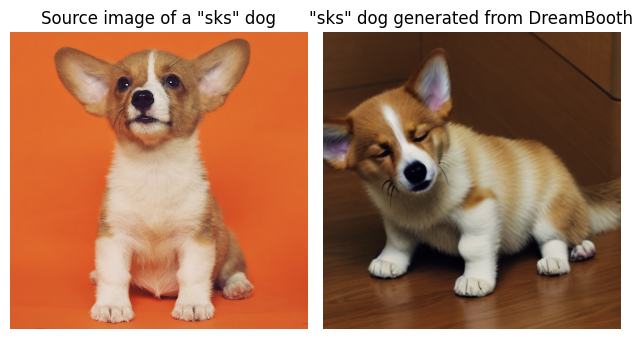

In [15]:
from PIL import Image
import matplotlib.pyplot as plt

x0 = Image.open('/datasets/instance_dir/image01.jpg')
x1 = Image.open('./DreamBooth_output/a photo of a sks dog sleeping_2.png')

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(x0)
ax1.axis('off')
ax1.set_title('Source image of a "sks" dog')
ax2.imshow(x1)
ax2.axis('off')
ax2.set_title('"sks" dog generated from DreamBooth')

plt.tight_layout()
plt.show()